# Sprint 6 Project
**Zuber Analyst**

---
Project description

You're working as an analyst for Zuber, a new ride-sharing company that's launching in Chicago. Your task is to find patterns in the available information. You want to understand passenger preferences and the impact of external factors on rides.

Working with a database, you'll analyze data from competitors and test a hypothesis about the impact of weather on ride frequency.

---

We have done some initial work outside of this Notebook already, using Python to scrape the data from a website, and then using SQL to more deeply explore the data once it's been neatly structured into a database. 

We prepared a few queries for further hypothesis testing using Python, which we will tackle further in this Notebook. 

---

Below is the original data we worked with, along with the results of the queries we executed:

**Original Data**\
`neighborhoods` table: data on city neighborhoods

`name`: name of the neighborhood\
`neighborhood_id`: neighborhood code

`cabs` table: data on taxis

`cab_id`: vehicle code\
`vehicle_id`: the vehicle's technical ID\
`company_name`: the company that owns the vehicle

`trips` table: data on rides

`trip_id`: ride code\
`cab_id`: code of the vehicle operating the ride\
`start_ts`: date and time of the beginning of the ride (time rounded to the hour)\
`end_ts`: date and time of the end of the ride (time rounded to the hour)\
`duration_seconds`: ride duration in seconds\
`distance_miles`: ride distance in miles\
`pickup_location_id`: pickup neighborhood code\
`dropoff_location_id`: dropoff neighborhood code

`weather_records` table: data on weather

`record_id`: weather record code\
`ts`: record date and time (time rounded to the hour)\
`temperature`: temperature when the record was taken\
`description`: brief description of weather conditions, e.g. "light rain" or "scattered clouds"

**Query Results**\
**`project_sql_result_01.csv`**. It contains the following data:

`company_name`: taxi company name\
`trips_amount`: the number of rides for each taxi company on November 15-16, 2017.
 
 
**`project_sql_result_04.csv`**. It contains the following data:

`dropoff_location_name`: Chicago neighborhoods where rides ended\
`average_trips`: the average number of rides that ended in each neighborhood in November 2017.

**`project_sql_result_07.csv`** — the result of the last query. It contains data on rides from the Loop to O'Hare International Airport. Remember, these are the table's field values:

`start_ts` — pickup date and time\
`weather_conditions` — weather conditions at the moment the ride started\
`duration_seconds` — ride duration in seconds

### Importing

In [1]:
# importing libraries

import pandas as pd
import math
from scipy import stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# reading in datasets 

rides_per_company = pd.read_csv('/datasets/project_sql_result_01.csv')

trips_per_location = pd.read_csv('/datasets/project_sql_result_04.csv')

loop_ohare = pd.read_csv('/datasets/project_sql_result_07.csv')

In [3]:
# inspecting dataframes

rides_per_company.info()

rides_per_company.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [4]:
trips_per_location.info()

trips_per_location.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [5]:
loop_ohare.info()

loop_ohare.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


**Observations**

Data types look fine, aside from `start_ts` in `loop_ohare` being an object -- we'll want to turn that into datetime in case we need such calculations in the future.

### Cleaning Data

In [6]:
loop_ohare['start_ts'] = pd.to_datetime(loop_ohare['start_ts'], format='%Y-%m-%d %H:%M:%S')

loop_ohare.info()
loop_ohare.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


### Exploratory Data Analysis

**Identifying the top 10 neighborhoods by drop-offs**

In [7]:
# sorting our trips_per_location df and looking at the top 10 neighborhoods

trips_per_location = trips_per_location.sort_values(by='average_trips', ascending=False)

trips_per_location.head(10)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


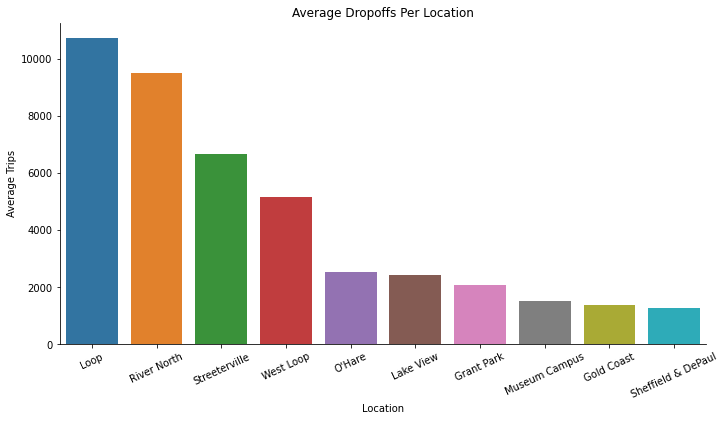

In [8]:
# plotting a boxplot of the top ten dropoff locations

top_locations = trips_per_location.head(10)

sns.catplot(kind='bar',
            data=top_locations,
            x='dropoff_location_name',
            y='average_trips',
            height=5,
            aspect=2
           )

plt.title('Average Dropoffs Per Location')
plt.xlabel('Location')
plt.ylabel('Average Trips')
plt.xticks(rotation = 25)
plt.show()

**Observations**

We can clearly see that Loop is the most common dropoff location. The interesting part is how much of a lead the top 4 locations have over the rest of the top 10. 

Loop, River North, Streeterville and West Loop are all significantly more popular than the rest of the locations, which taper off to roughly similar amounts. 

Without having intimiate knowledge of the Chicago area, we may be able to conclude that these 4 locations are very important to travels, because they go there very frequently. 

**Identifying top taxi companies**

In [9]:
# sorted out rides_per_company df to identify the top 10 taxi companies by number of rides

rides_per_company = rides_per_company.sort_values(by='trips_amount', ascending=False)

rides_per_company.head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


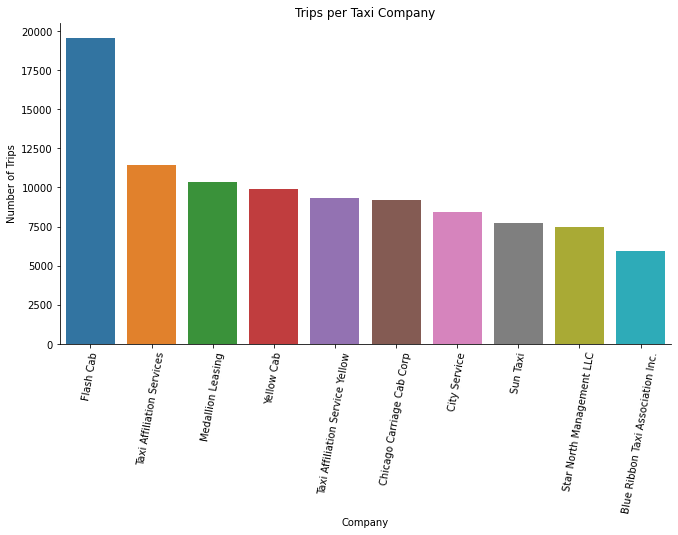

In [10]:
# plotting this, similar to above

top_companies = rides_per_company.head(10)

sns.catplot(kind='bar',
            data=top_companies,
            x='company_name',
            y='trips_amount',
            height=5,
            aspect=2
           )

plt.title('Trips per Taxi Company')
plt.xlabel('Company')
plt.ylabel('Number of Trips')
plt.xticks(rotation = 80)
plt.show()

**Observations**

Flash Cab is wildly more popular than all the rest of the taxi companies -- nearly double the trips! The other 9 are all much more similar, with a gradual decline between number 2 and number 9. This tells us just how much bigger and more popular Flash Cab is than all the rest. 

### Testing Hypotheses

We will be testing the following hypothesis, using the data we generated from the database, stored in our `loop_ohare` dataframe:

"The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays." 

*Null Hypothesis*: The average duration of rides from the Loop to O'Hare International Airport does not change on rainy Saturdays.

*Alternative Hypothesis*: The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

In [11]:
# creating a day_of_week column to identify only saturdays
loop_ohare["day_of_week"] = loop_ohare["start_ts"].dt.dayofweek

print(loop_ohare["day_of_week"].value_counts())

5    1068
Name: day_of_week, dtype: int64


Interestingly, it seems we *only* have Saturday in our data. That makes this easier.

In [12]:
# splitting our loop_ohare dataframe into two samples, for good and rainy weather

good_saturdays = loop_ohare.query('weather_conditions == "Good"')

bad_saturdays = loop_ohare.query('weather_conditions == "Bad"')

display(good_saturdays.head())
display(bad_saturdays.head())

,start_ts,weather_conditions,duration_seconds,day_of_week
0,2017-11-25 16:00:00,Good,2410.0,5
1,2017-11-25 14:00:00,Good,1920.0,5
2,2017-11-25 12:00:00,Good,1543.0,5
3,2017-11-04 10:00:00,Good,2512.0,5
4,2017-11-11 07:00:00,Good,1440.0,5


,start_ts,weather_conditions,duration_seconds,day_of_week
6,2017-11-04 16:00:00,Bad,2969.0,5
30,2017-11-18 12:00:00,Bad,1980.0,5
34,2017-11-04 17:00:00,Bad,2460.0,5
51,2017-11-04 16:00:00,Bad,2760.0,5
52,2017-11-18 12:00:00,Bad,2460.0,5


In [13]:
# testing our hypothesis

alpha = 0.05 

results = st.ttest_ind(good_saturdays['duration_seconds'], bad_saturdays['duration_seconds'], equal_var=False)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 6.738994326108734e-12
We reject the null hypothesis


**Observations**

After running our test, we have sufficient evidence to reject the null hypothesis, meaning that there is a statistically significant difference between the average duration of rides from Loop to O'Hare on rainy Saturdays vs good weather Saturdays. 

We do not yet know what the difference is, but we can certainly find out. 

Regarding the test, I chose an alpha value of 0.05, because it is the popularly accepted significance level for hypothesis testing. I used `st.ttest_ind` because we are testing the means of two independent samples, that do not have an equal variance between them. 

In [14]:
# looking at the average duration of good weather rides and bad weather rides

good_average = good_saturdays['duration_seconds'].mean()
bad_average = bad_saturdays['duration_seconds'].mean()

print('Average ride duration on good weather Saturdays:', good_average)
print('Average ride duration on bad weather Saturdays:', bad_average)

Average ride duration on good weather Saturdays: 1999.6756756756756
Average ride duration on bad weather Saturdays: 2427.2055555555557


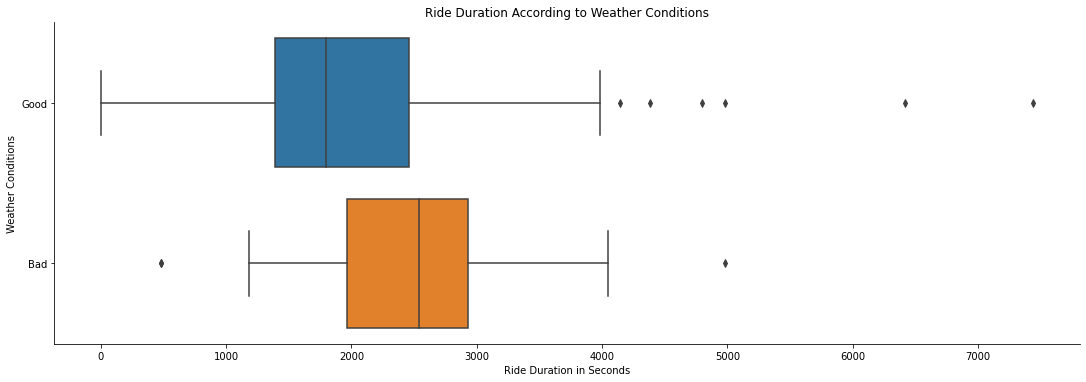

In [15]:
# plotting this to understand the magnitude in difference
d={'weather_conditions': loop_ohare['weather_conditions'], 'duration_seconds': loop_ohare['duration_seconds']}
loop_ohare_dist = pd.DataFrame(data=d)

sns.catplot(kind='box',
           data=loop_ohare_dist,
           x='duration_seconds',
           y='weather_conditions',
            height=5,
            aspect=3
           )

plt.title('Ride Duration According to Weather Conditions')
plt.xlabel('Ride Duration in Seconds')
plt.ylabel('Weather Conditions')
plt.show()
    

**Observations**

Looking at both our mean data and the box plot, we can confidently conclude that the average ride duration is longer on rainy Saturdays. 

### Conclusion

Throughout this project, I followed through on the full process of scraping the data from a website, querying it once it was stored in an organized SQL database, and analyzing the database exports using Python.

I was able to pull some helpful data slices using SQL so that we could further analyze that data using Python, in a useful way. 

I was able to find the top 10 Taxi companies, which was unanimously Flash Cab, by a landslide. They are significantly more popular than any other Taxi company.

I identified the most popular dropoff locations, with the top 4 of those locations, Loop, River North, Streeterville and West Loop, all being significantly more popular than the rest of the top 10. We concluded earlier that those locations are likely important to the average traveler, since so  many people end up there. 

Finally, I tested the hypothesis that the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays. 

I created the following Null and Alternative hypotheses:

*Null Hypothesis*: The average duration of rides from the Loop to O'Hare International Airport does not change on rainy Saturdays.

*Alternative Hypothesis*: The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

The results of the test led me to being able to reject the Null hypothesis, which I then dug deeper to figure out the real story of the data. we can confidently conclude that the average ride duration is longer on rainy Saturdays. 